SIMBAD:
http://simbad.u-strasbg.fr/simbad/sim-id?Ident=IRAS%2018089-1732

maser paper dall'olio
https://ui.adsabs.harvard.edu/abs/2017A%26A...607A.111D/abstract

distance
Immer: http://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2013A%26A...553A.117I
Xu: http://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2011ApJ...733...25X

Sanhueza: https://ui.adsabs.harvard.edu/abs/2021ApJ...915L..10S/abstract

In [2]:
from astropy import units as u
distance = 2.34*u.kpc # xu 2011
vcen = 32 * u.km/u.s # from Patricio


In [3]:
cd /orange/adamginsburg/salt/sanhueza/IRAS18089/

/orange/adamginsburg/salt/sanhueza/IRAS18089


In [4]:
ls

continuumcutout.reg
continuumpolygon.reg
diskbox.reg
innerdiskbox.reg
IRAS_180891732.config8.cont_avg.selfcal_0.5_hogbom.image.fits*
IRAS_180891732.config8.spw0.robust0.5.image_cb_smaller.fits
IRAS_180891732.config8.spw0.robust0.5.image_cb_smaller.fits.fits
IRAS_180891732.config8.spw0.robust0.5.image_small.fits*
IRAS_180891732.config8.spw1.robust0.5.image_cb_smaller.fits
IRAS_180891732.config8.spw1.robust0.5.image_cb_smaller.fits.fits
IRAS_180891732.config8.spw1.robust0.5.image_small.fits*
IRAS_180891732.config8.spw2.robust0.5.image_cb_smaller.fits
IRAS_180891732.config8.spw2.robust0.5.image_cb_smaller.fits.fits
IRAS_180891732.config8.spw2.robust0.5.image_small.fits*
IRAS_180891732.config8.spw3.robust0.5.image_cb_smaller.fits
IRAS_180891732.config8.spw3.robust0.5.image_cb_smaller.fits.fits
IRAS_180891732.config8.spw3.robust0.5.image_small.fits*
IRAS_180891732.zip*
NaCl_v_le_3_stackcube.fits
spectra/


In [5]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2aba1e222550>

In [6]:
from astropy.table import Table
from astropy import table

In [7]:
import pprint

In [8]:
import scipy, scipy.ndimage

In [9]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord, visualization
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [10]:
import regions
from astropy import units as u, coordinates
reg = regions.Regions.read('continuumcutout.reg')
regsm = regions.Regions.read('continuumpolygon.reg')
regvsm = regions.Regions.read('diskbox.reg')
regvvsm = regions.Regions.read('innerdiskbox.reg')

In [11]:
regvvsm[0].center.to_string('hmsdms')

'18h11m51.45672s -17d31m28.794s'

(2302.0, 2628.0, 2366.0, 2675.0)

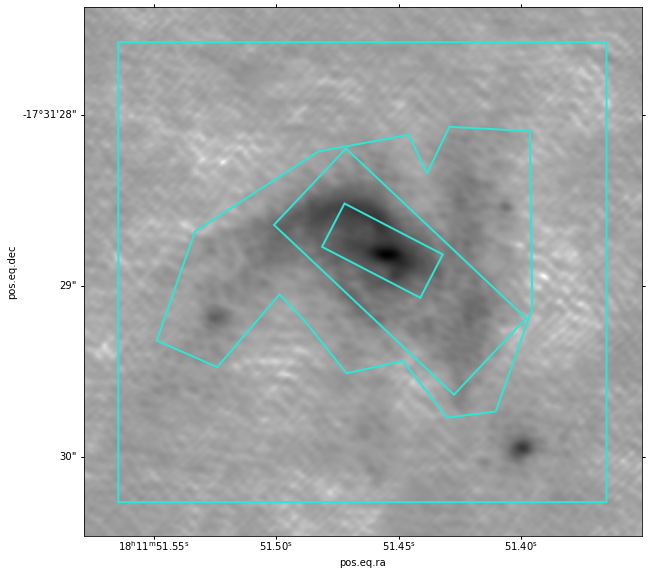

In [12]:
cont = SpectralCube.read('IRAS_180891732.config8.cont_avg.selfcal_0.5_hogbom.image.fits')
pl.figure(figsize=(10,10))
ax = pl.subplot(projection=cont[0].wcs)
ax.imshow(cont[0].value, cmap='gray_r', norm=visualization.simple_norm(cont[0].value, stretch='log'))
reg[0].to_pixel(cont[0].wcs).plot(ax=ax)
regsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
regvsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
regvvsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
pp = reg[0].to_pixel(cont.wcs.celestial)
bb = pp.bounding_box
ax.axis([bb.ixmin-20, bb.ixmax+20, bb.iymin-20, bb.iymax+20])

# NaCl Stackl

In [13]:
from spectral_cube.analysis_utilities import stack_cube

In [14]:
nacltables = salt_tables[3:5]
#nacltables[0]

In [15]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [16]:
flist = (glob.glob('IRAS_180891732.config8.spw[0-3].robust0.5.image_small.fits'))

In [17]:
for fn in flist:
    outfile = fn.replace("_small","_cb_smaller")
    if not os.path.exists(outfile) or SpectralCube.read(outfile).unit != u.K:
        cube = SpectralCube.read(fn).subcube_from_regions(reg)
        cube.allow_huge_operations=True
        cb = cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
        scube = cube.convolve_to(cb).to(u.K)
        scube.write(outfile, overwrite=True)

In [18]:
cubes = [SpectralCube.read(fn, use_dask=True).subcube_from_regions(reg)
         for fn in (glob.glob('IRAS_180891732.config8.spw[0-3].robust0.5.image_cb_smaller.fits'))]
cubes

[DaskSpectralCube with shape=(1920, 269, 285) and unit=K and chunk size (240, 255, 255):
  n_x:    285  type_x: RA---SIN  unit_x: deg    range:   272.964023 deg:  272.964850 deg
  n_y:    269  type_y: DEC--SIN  unit_y: deg    range:   -17.525072 deg:  -17.524328 deg
  n_s:   1920  type_s: FREQ      unit_s: Hz     range: 216862811005.700 Hz:218736848092.415 Hz,
 DaskSpectralCube with shape=(1920, 269, 285) and unit=K and chunk size (240, 255, 255):
  n_x:    285  type_x: RA---SIN  unit_x: deg    range:   272.964023 deg:  272.964850 deg
  n_y:    269  type_y: DEC--SIN  unit_y: deg    range:   -17.525072 deg:  -17.524328 deg
  n_s:   1920  type_s: FREQ      unit_s: Hz     range: 231062799893.000 Hz:232936836979.833 Hz,
 DaskSpectralCube with shape=(3840, 269, 285) and unit=K and chunk size (240, 255, 255):
  n_x:    285  type_x: RA---SIN  unit_x: deg    range:   272.964023 deg:  272.964850 deg
  n_y:    269  type_y: DEC--SIN  unit_y: deg    range:   -17.525072 deg:  -17.524328 deg
  n_s: 

In [19]:
# only needed for VRSCs
if hasattr(cubes[0], 'beams'):
    beams = radio_beam.Beams(beams=[cube.beams.common_beam(max_iter=20, max_epsilon=0.01) for cube in cubes])
    cb=beams.common_beam()
else:
    beams = radio_beam.Beams(beams=[cube.beam for cube in cubes])
    cb=beams.common_beam()

In [20]:
cb

Beam: BMAJ=0.06362952127481811 arcsec BMIN=0.04580573756497626 arcsec BPA=66.56417045752602 deg

In [21]:
(cb.major*distance).to(u.au, u.dimensionless_angles())

<Quantity 148.89307978 AU>

In [22]:
(cb.minor*distance).to(u.au, u.dimensionless_angles())

<Quantity 107.1854259 AU>

In [23]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=1-1 J=18-17', '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [24]:
from astropy import log
log.setLevel('INFO')

In [25]:
#log.setLevel('DEBUG')
vcen = 32 * u.km/u.s # from Patricio
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=vcen-30*u.km/u.s,
                   vmax=vcen+30*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.write('NaCl_v_le_3_stackcube.fits', overwrite=True)

In [26]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits', use_dask=True)
stackc

DaskSpectralCube with shape=(46, 269, 285) and unit=K and chunk size (46, 269, 285):
 n_x:    285  type_x: RA---SIN  unit_x: deg    range:   272.964023 deg:  272.964850 deg
 n_y:    269  type_y: DEC--SIN  unit_y: deg    range:   -17.525072 deg:  -17.524328 deg
 n_s:     46  type_s: VRAD      unit_s: km / s  range:        1.652 km / s:      62.091 km / s

In [27]:
jtok = stackc.beam.jtok(217*u.GHz)

(2302.0, 2628.0, 2366.0, 2675.0)

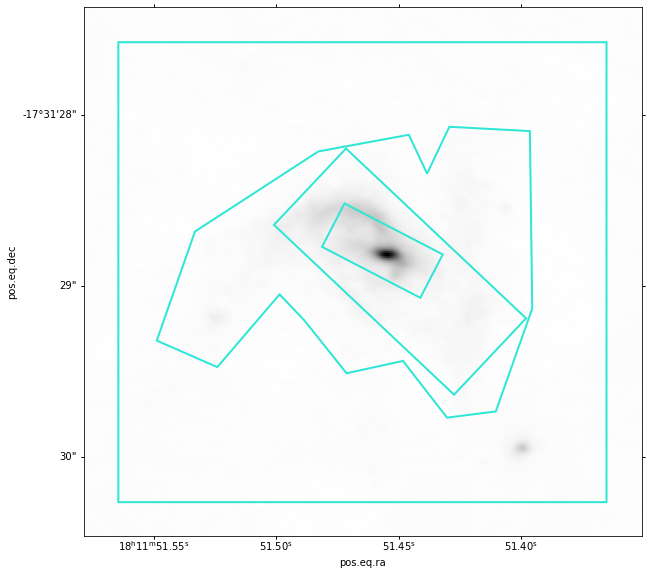

In [28]:
cont = SpectralCube.read('IRAS_180891732.config8.cont_avg.selfcal_0.5_hogbom.image.fits')
pl.figure(figsize=(10,10))
ax = pl.subplot(projection=cont[0].wcs)
ax.imshow(cont[0].value, cmap='gray_r')
reg[0].to_pixel(cont[0].wcs).plot(ax=ax)
regsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
regvsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
regvvsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
pp = reg[0].to_pixel(cont.wcs.celestial)
bb = pp.bounding_box
ax.axis([bb.ixmin-20, bb.ixmax+20, bb.iymin-20, bb.iymax+20])

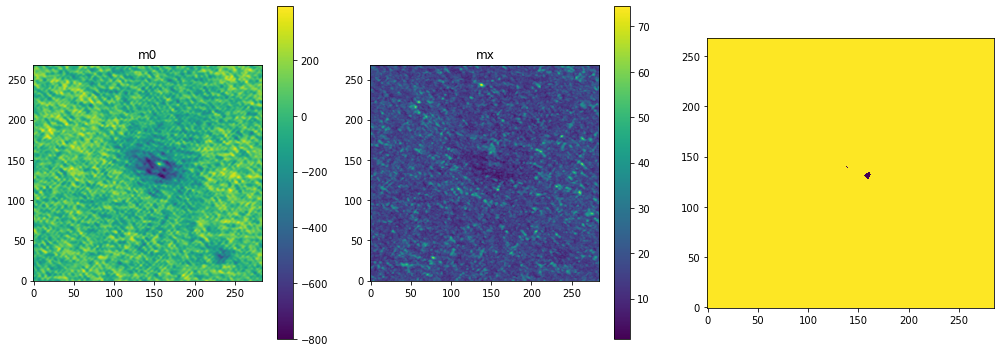

<Figure size 432x288 with 0 Axes>

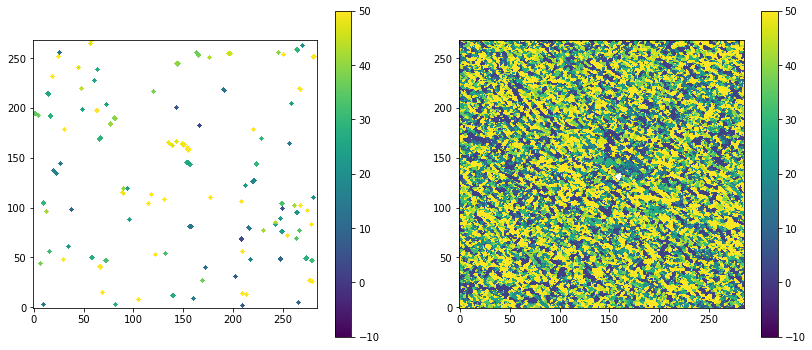

In [30]:
stackc = stackc.subcube_from_regions(reg)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
im = pl.imshow(m0.value)
pl.colorbar(mappable=im)
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
im = pl.imshow(mx.value)
pl.title("mx")
pl.colorbar(mappable=im)
pl.subplot(1,3,3)
msk = mx > 10*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()

from dask_image.ndmorph import binary_dilation, binary_erosion
m3d = (stackc > 15*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
m3d = m3d.compute()


m1 = stackc.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-10, vmax=50)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
im = pl.imshow(mxv.value, vmin=-10, vmax=50)
pl.colorbar(mappable=im)


#vmap = mxv.hdu
#vmap = m1.hdu
#vmap = mxv.hdu

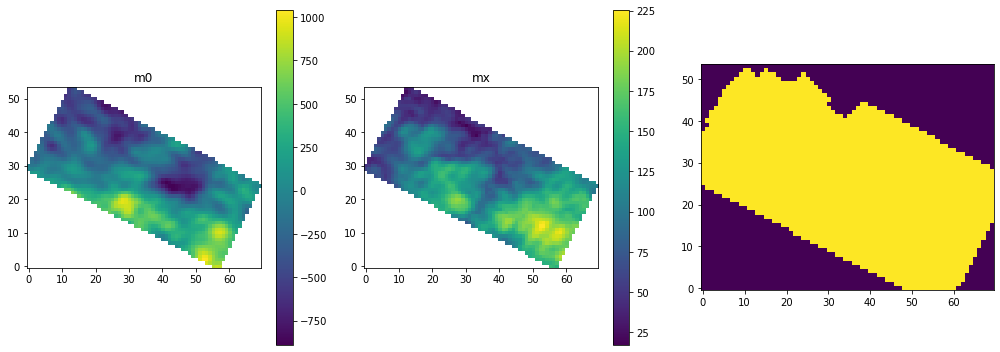

<Figure size 432x288 with 0 Axes>

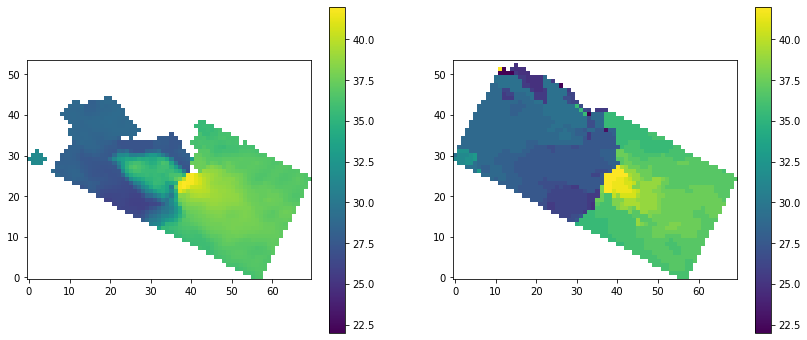

In [36]:
# make moment map of SO 65-54
restval = 219.94944000*u.GHz # SO 65-54

cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]

scube = cube.subcube_from_regions(regvvsm).with_spectral_unit(u.km/u.s,
                                                             velocity_convention='radio',
                                                             rest_value=restval).spectral_slab(vcen-20*u.km/u.s, vcen+20*u.km/u.s)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
im = pl.imshow(m0.value)
pl.colorbar(mappable=im)

pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
im = pl.imshow(mx.value)
pl.title("mx")
pl.colorbar(mappable=im)
pl.subplot(1,3,3)
msk = mx > 50*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()


from dask_image.ndmorph import binary_dilation, binary_erosion
m3d = (scube > 60*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
m3d = m3d.compute()



m1 = scube.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-10, vmax=vcen.value+10)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
im = pl.imshow(mxv.value, vmin=vcen.value-10, vmax=vcen.value+10)
pl.colorbar(mappable=im)

vmapm1 = m1.hdu
vmap = mxv.hdu
# the rest value selected above was just the line center; we need to assume it's really 35 km/s off
vmap.data = vmap.data
vmap = mxv.hdu

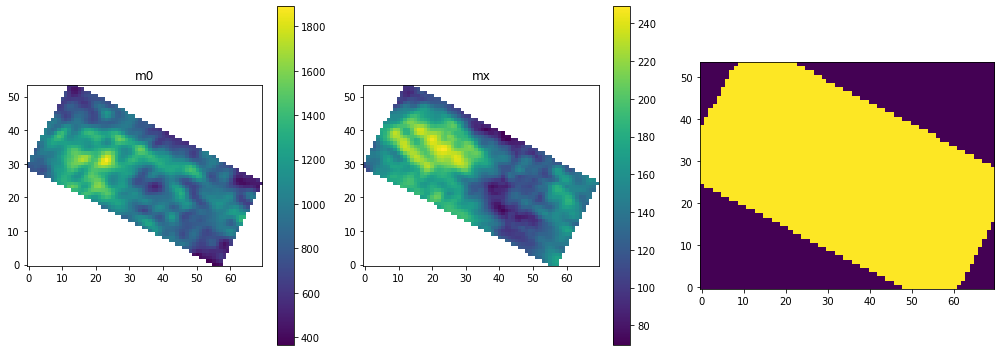

<Figure size 432x288 with 0 Axes>

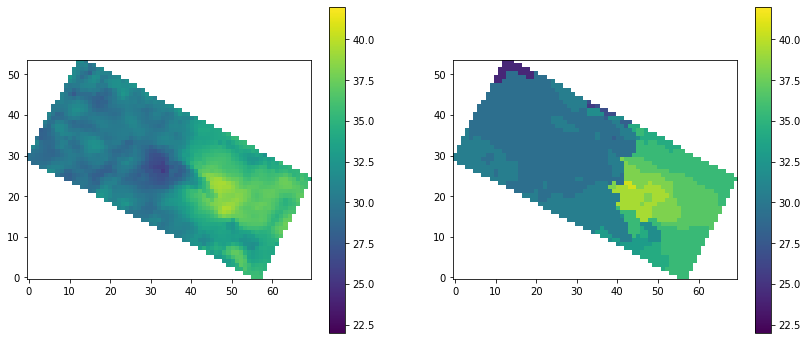

In [37]:
# try creating a vmap based on another line
restval = 232.3929*u.GHz
restval = 232.4195*u.GHz*(1-32*u.km/u.s/constants.c) # CH3OH 7(6,1)-7(7,0)vt=1	
restval = 232.418521*u.GHz # CH3OH 10(2,8)-9(3,7)A,vt=0	

# other options? 234.16 GHz?

cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
scube = cube.subcube_from_regions(regvvsm).with_spectral_unit(u.km/u.s, velocity_convention='radio',
                                                              rest_value=restval).spectral_slab(vcen-20*u.km/u.s, vcen+20*u.km/u.s)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
im = pl.imshow(m0.value)
pl.colorbar(mappable=im)
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
im = pl.imshow(mx.value)
pl.title("mx")
pl.colorbar(mappable=im)
pl.subplot(1,3,3)
msk = mx > 20*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()


from dask_image.ndmorph import binary_dilation, binary_erosion
m3d = (scube > 15*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
m3d = m3d.compute()


m1 = scube.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-10, vmax=vcen.value+10)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
im = pl.imshow(mxv.value, vmin=vcen.value-10, vmax=vcen.value+10)
pl.colorbar(mappable=im)


#vmap = mxv.hdu
# the rest value selected above was just the line center; we need to assume it's really 32 km/s off
#vmap.data = vmap.data + vcen.value

In [39]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
from overplot_saltlines import overplot_saltlines

In [40]:
spectra = []
for ii,cube in enumerate(cubes):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(regvvsm).mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra.append(pysp)
    pysp.specname = f'spw{ii+1}'

In [41]:
mkdir -p spectra/figures

spw1
spw2
spw3
spw4


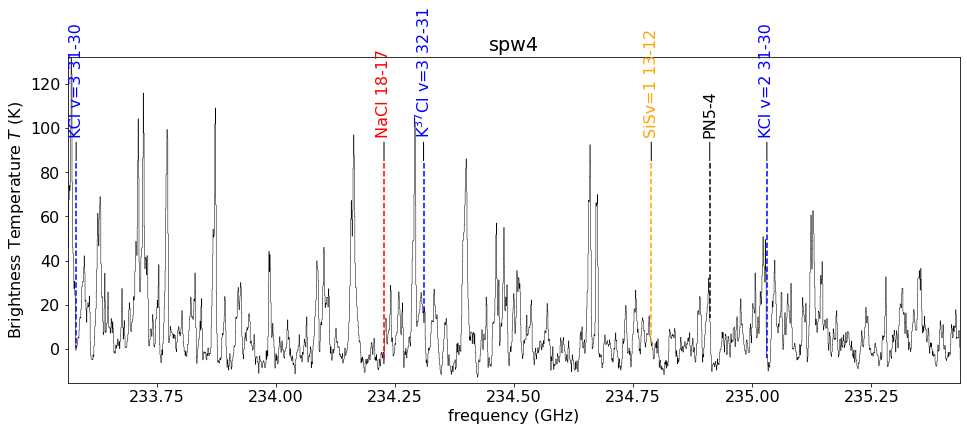

In [42]:
overplot_saltlines(spectra, vcen=vcen, savepath='spectra/figures')

In [43]:
ls spectra/figures

color_labels_IRAS_180891732_spw0_stack.png
color_labels_IRAS_180891732_spw1_stack.png
color_labels_IRAS_180891732_spw2_stack.png
color_labels_IRAS_180891732_spw3_stack.png
color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
IRAS_180891732.config8.spw0.robust0.5.image_cb_smaller_stack.pdf
IRAS_180891732.config8.spw0.robust0.5.image_cb_smaller_stack.png
IRAS_180891732.config8.spw1.robust0.5.image_cb_smaller_stack.pdf
IRAS_180891732.config8.spw1.robust0.5.image_cb_smaller_stack.png
IRAS_180891732.config8.spw2.robust0.5.image_cb_smaller_stack.pdf
IRAS_180891732.config8.spw2.robust0.5.image_cb_smaller_stack.png
IRAS_180891732.config8.spw3.robust0.5.image_cb_smaller_stack.pdf
IRAS_180891732.config8.spw3.robust0.5.image_cb_smaller_stack.png
IRAS_180891732_spw0_stack.png
IRAS_180891732_spw1_stack.png
IRAS_180891732_spw2_stack.png
IRAS_180891732_spw3_stack.png
spw1.png
spw2.png
spw3.png
spw4.png


In [44]:
from IPython.display import Image,display

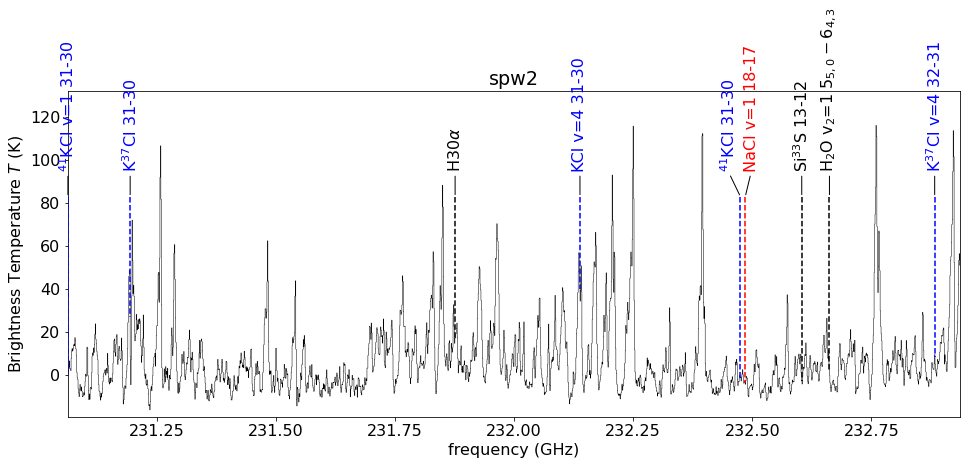

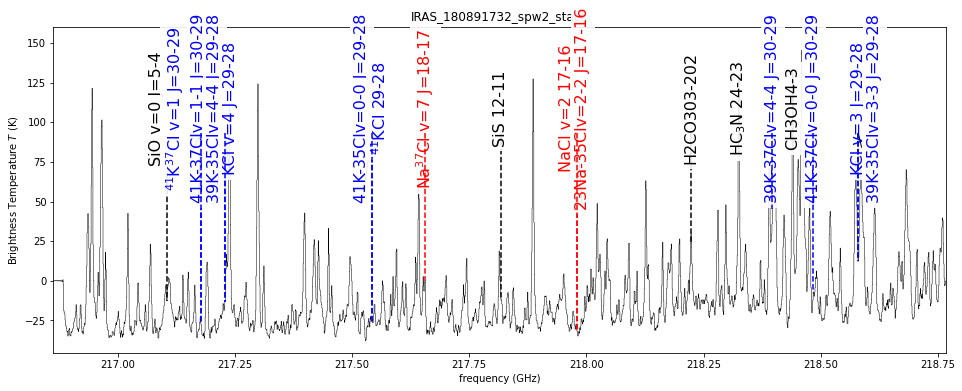

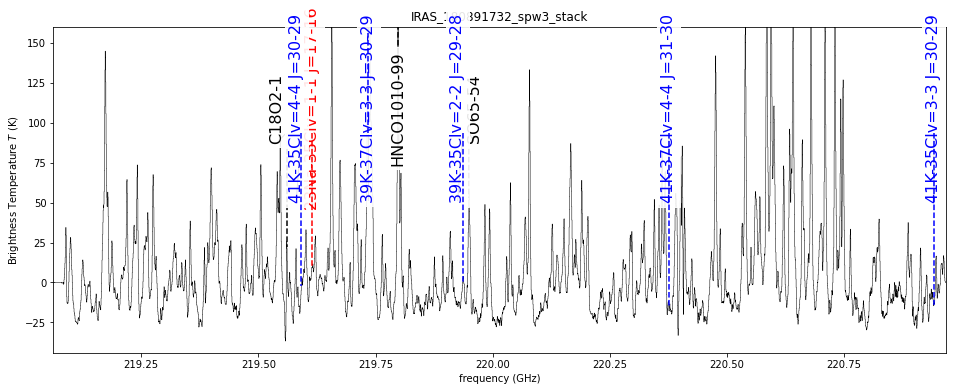

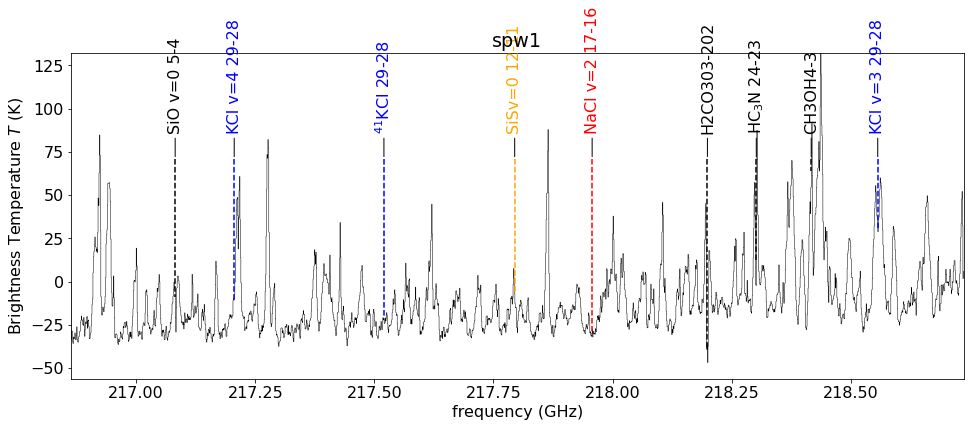

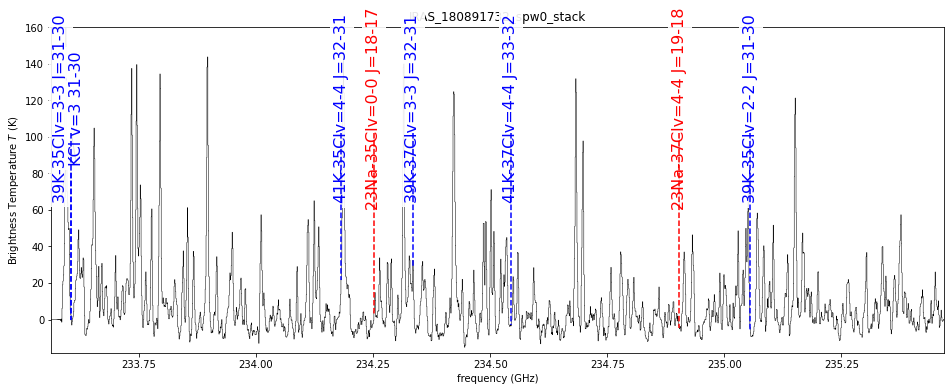

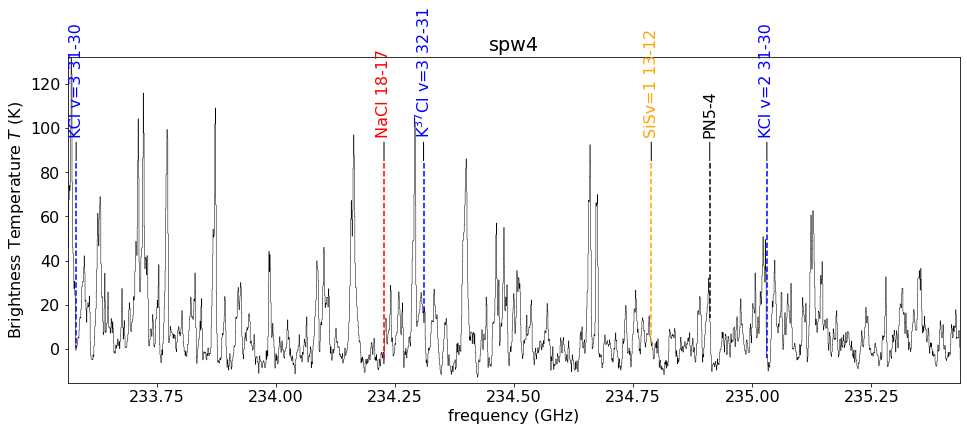

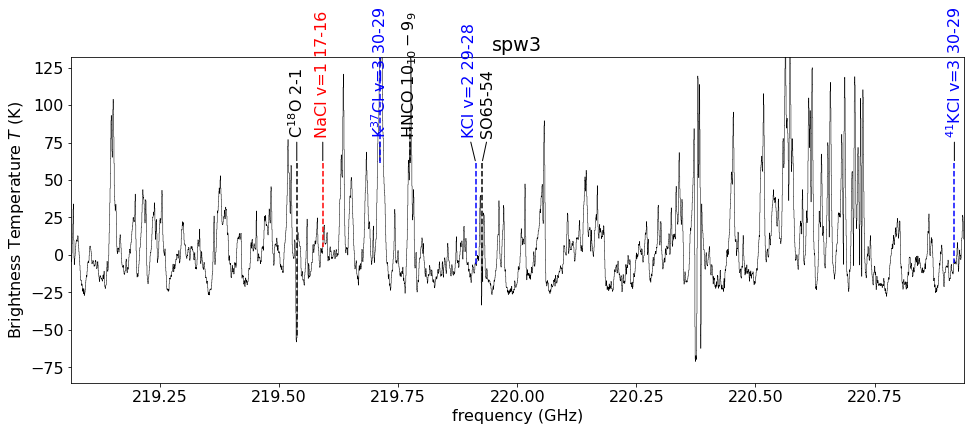

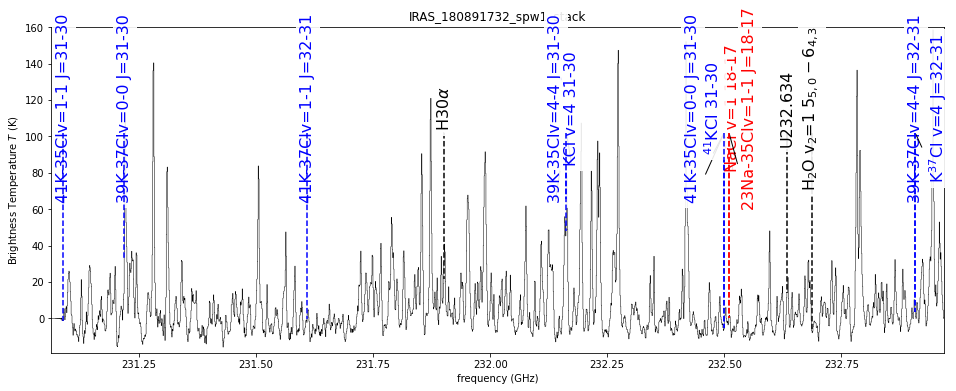

In [45]:
for fn in glob.glob('spectra/figures/color*png'):
    display(Image(fn))

In [46]:
import glob
import spectral_cube.analysis_utilities
import reproject
from tqdm.notebook import tqdm

cbflist = (glob.glob('IRAS_180891732.config8.spw[0-3].robust0.5.image_cb_smaller.fits'))
for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(regvvsm).to(u.K)
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)
    fits.PrimaryHDU(data=vmap_proj, header=scube.wcs.celestial.to_header()).writeto('vmap.fits')
    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

DaskSpectralCube with shape=(1920, 269, 285) and unit=K and chunk size (240, 255, 255):
 n_x:    285  type_x: RA---SIN  unit_x: deg    range:   272.964023 deg:  272.964850 deg
 n_y:    269  type_y: DEC--SIN  unit_y: deg    range:   -17.525072 deg:  -17.524328 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 216862811005.700 Hz:218736848092.415 Hz


Mean spectrum


NameError: name 'fits' is not defined

In [ ]:
ls spectra

In [ ]:
stackspectra = []
for ii,fn in enumerate(glob.glob('spectra/*_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'{spl[0]}_{spl[2]}_stack'
    stackspectra.append(pysp)

In [ ]:
overplot_saltlines(stackspectra, vcen=0*u.km/u.s, savepath='spectra/figures')

In [ ]:
pwd

In [ ]:
ls spectra/figures/

In [ ]:
for fn in glob.glob('spectra/figures/color*stack.png'):
    display(Image(fn))

In [ ]:
from astropy.stats import mad_std
for sp in stackspectra:
    print(stats.mad_std(sp.data))